In [1]:
# Define Neo4j connections
import pandas as pd
from neo4j import GraphDatabase
host = 'bolt://3.235.89.19:7687'
user = 'neo4j'
password = 'ballast-set-proficiencies'
driver = GraphDatabase.driver(host,auth=(user, password))

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# A deep dive into Neo4j Link Prediction pipeline and FastRP embedding algorithm
### Learn how to train and optimize Link Prediction models in the Neo4j Graph Data Science library to get the best results
In my previous blog post, I introduced the newly available Link Prediction pipeline in the Neo4j Graph Data Science library. Since the post, I took more time to dig deeper and learn the inner workings of the pipeline. I've learned a couple of things along the way that I want to share with you. At first, I intended to show how the Link Prediction pipeline combines node properties to generate input features of the Link Prediction model. However, when I was developing the content, I noticed a couple of insights about using the FastRP embedding algorithm. Therefore, by the end of this blog post, you will hopefully learn more about the FastRP embedding model and how you can combine multiple node features as an input to the Link Prediction model.
# Graph import
I had to find a small network so I easily visualize results as we go along. I decided to use the interaction network from the first season of the Game of Thrones TV show made available by Andrew Beveridge.
The graph model consists of characters and their interactions. We will treat the interaction relationship as undirected, where is character A interacts with character B, this directly implies that character B also interacted with character A. We also know how many times two characters interacted, and we store that information as the relationship property.
If you want to follow along with examples in this post, I recommend using a Blank project in Neo4j Sandbox. It is a free cloud instance of Neo4j database that comes pre-installed with both APOC and Graph Data Science plugins.
The dataset is available on GitHub, so we can easily import it into Neo4j with the following Cypher query:

In [2]:
run_query("""
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s1-edges.csv" as row
MERGE (s:Character{name:row.Source})
MERGE (t:Character{name:row.Target})
MERGE (s)-[i:INTERACTS]-(t)
SET i.weight = toInteger(row.Weight)
""")

""


Link prediction pipeline
Under the hood, the link prediction model in Neo4j uses a logistic regression classifier. We are dealing with a binary classification problem, where we want to predict if a link exists between a pair of nodes or not. On a high level, the link prediction pipeline follows the following steps:
* Node Feature engineering
* Link Feature combiner
* Model training
* Predict new links 

In this post, we will focus on the first two steps.
As a first step, you have to define node features. For example, you could use custom node properties such as age or gender. You can also use graph algorithms such as PageRank or Betweenness centrality as initial node features. In this blog post, we will start by using FastRP node embeddings to define initial node features. The nice thing about the FastRP embedding algorithm is that it captures the network information and preserves the similarity in embedding space between neighboring nodes that are close in a graph. At the moment, you can't use pairwise information such as the number of common neighbors or the length of the shortest path between a pair of nodes as input features.
In the second step, the link feature combiner creates a single feature from a pair of node properties. Currently, there are three techniques that you can use to combine a pair of node properties into a single link feature vector:
* Cosine distance
* L2 or Euclidian distance
* Hadamard product

All the available link feature combiner techniques are order-invariant as the Link Prediction pipeline supports predicting only undirected relationships at the moment. You can use multiple link feature combiners in a single pipeline to define several feature vectors, which are then concatenated as an input to the Link Prediction model. I'll walk you through an example later in the post.
Once the node features and link feature combiner are defined, you can train the model to predict new connections.
# Node Feature engineering
You can preprocess node features before defining the Link Prediction pipeline. You can also include them directly in the pipeline definition if you only use graph algorithms such as node embeddings or centrality measures as node features. In the first example, we will use the FastRP embeddings as our Link Prediction model node features. Therefore, we could potentially include them in the pipeline definition. However, we will first do a short analysis of the node embedding results, so we need to store the node embeddings to the graph before diving into the pipeline definition. We start by projecting an undirected named graph. Take a look at the documentation for more information about the inner workings of the Graph Data Science library.

In [3]:
run_query("""
CALL gds.graph.create('gots1', 'Character', {INTERACTS:{orientation:'UNDIRECTED', properties:'weight'}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,"{'Character': {'properties': {}, 'label': 'Cha...","{'INTERACTS': {'orientation': 'UNDIRECTED', 'a...",gots1,126,1098,513


We will use Louvain, a community detection algorithm, to help us better understand the results of the FastRP embedding algorithm. You can use the following Cypher query to store the community structure information back to the database.

In [4]:
run_query("""
CALL gds.louvain.write('gots1', {writeProperty:'louvain', relationshipWeightProperty:'weight'})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,404,126,0.528858,"[0.5016739965172651, 0.5288576612285539]",2,7,"{'p99': 45, 'min': 2, 'max': 45, 'mean': 18.0,...",98,1,2598,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


Throughout this blog post, I will be using Neo4j Bloom to visualize the results of algorithms and link predictions. Take a look at this guide if you want to learn how to visualize networks with Bloom.

Now we can go ahead and execute the FastRP embedding algorithm. The algorithm will produce an embedding or a fixed-size vector for every node in the graph. My friend CJ Sullivan wrote an [excellent article](https://towardsdatascience.com/behind-the-scenes-on-the-fast-random-projection-algorithm-for-generating-graph-embeddings-efb1db0895) explaining the inner working of the FastRP algorithm.

In [5]:
run_query("""
CALL gds.fastRP.write('gots1', {writeProperty:'embedding', embeddingDimension:56, relationshipWeightProperty:'weight'})
""")

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,126,126,1,299,201,"{'writeConcurrency': 4, 'normalizationStrength..."


First, we will evaluate FastRP embeddings with a t-SNE scatter plot visualization. The stored node embeddings are vectors with a length of 56, as defined by the embeddingDimension parameter. The t-SNE algorithm is a dimensionality reduction algorithm, which we can use to reduce the embedding dimension to two. Having vectors with length two allows us to visualize them with a scatter plot. The Python code I used for dimensionality reduction and scatter plot visualization is:

In [6]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns


def tsne(embeddings, hue=None):
    tsne = TSNE(n_components=2, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

    embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
    embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne_x", y="tsne_y",
        hue=hue,
        palette="deep",
        data=embeddings,
        legend="full",
        alpha=0.9
    )
    # Add captions
    #for i in range(embeddings.shape[0]):
    #    plt.text(x=embeddings['tsne_x'][i]+0.3,y=embeddings['tsne_y'][i]+0.3,s=embeddings.character[i], 
    #          fontdict=dict(color='black',size=10),)

In [7]:
tsne_input = run_query("""
MATCH (c:Character)
RETURN c.name as character, c.embedding as embedding, c.louvain as hue 
""")

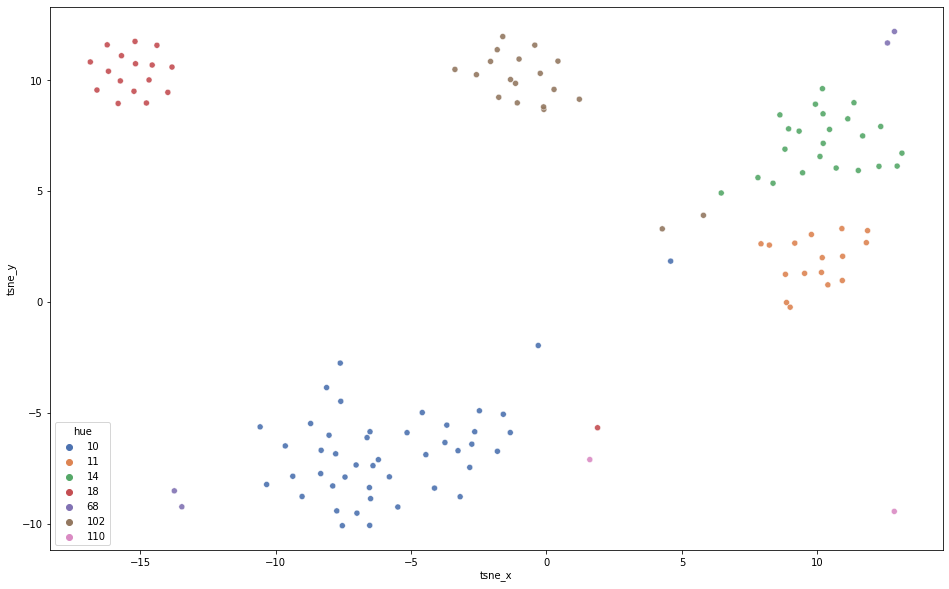

In [22]:
tsne(tsne_input, 'hue')

FastRP embeddings and the Louvain algorithm were executed independently, and yet, we can observe that FastRP embeddings cluster nodes in the same community close in the embedding space. This is no surprise as FastRP is a community-based node embedding algorithm, meaning that nodes close in the graph will be also close in the embedding space. Next, we will evaluate the cosine similarity between nodes in the graph.

In [10]:
run_query("""
MATCH (c:Character)
WITH {item:id(c), weights: c.embedding} AS userData
WITH collect(userData) AS data
CALL gds.alpha.similarity.cosine.stats({
  data: data,
  topK: 1000,
  similarityCutoff: 0.1
})
YIELD nodes, similarityPairs, min, max, mean, p25, p50, p75, p90, p95, p99
RETURN nodes, similarityPairs, min, max, mean, p25, p50, p75, p90, p95, p99
""")

,nodes,similarityPairs,min,max,mean,p25,p50,p75,p90,p95,p99
0,126,13546,0.100346,1.000007,0.537947,0.281726,0.496877,0.816959,0.964294,0.984401,0.99615


An average cosine similarity coefficient between all nodes in the graph is around 0.5. Around 25% of the node pairs have a cosine similarity greater than 0.81. Nodes are so similar in the embedding space because we have a tiny graph of only 126 nodes. Next, we will evaluate the cosine and euclidian distance between pairs of nodes connected by a relationship.

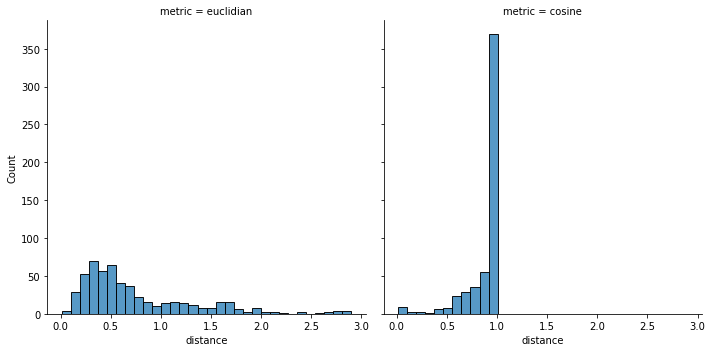

In [11]:
df = run_query("""
MATCH (c1:Character)-[:INTERACTS]->(c2:Character)
RETURN gds.alpha.similarity.euclideanDistance(c1.embedding, c2.embedding) AS distance, 'euclidian' as metric
UNION
MATCH (c1:Character)-[:INTERACTS]->(c2:Character)
RETURN gds.alpha.similarity.cosine(c1.embedding, c2.embedding) AS distance, 'cosine' as metric
""")

sns.displot(data=df, x='distance', col='metric')

Most node pairs that are connected with a relationship have a high cosine similarity. Again, this is expected as the FastRP is designed to translate the network topology structure into embedding space. Therefore, we expect the neighboring nodes in the graph to be very similar in the embedding space. We will examine the node pairs connected in the network with a cosine similarity of less than 0.5 as this is a bit more unexpected. First, we have to tag them with Cypher:

In [12]:
run_query("""
MATCH p=(c1:Character)-[i:INTERACTS]->(c2:Character)
WHERE gds.alpha.similarity.cosine(c1.embedding, c2.embedding) < 0.5
SET i.show = True
""")

""


It seems that pairs of connected nodes with a lower cosine similarity mainly occur when we have connections between various clusters or communities in the network. If you remember the t-SNE visualization, the nodes in the same community are nicely grouped in the embedding space. However, we have a couple of relationships between nodes from different communities. When we have connections between nodes from various communities, their similarity decreases. It also seems that these nodes have a higher degree, meaning they have many links within their community and then a couple of links to other communities. Therefore, they are more similar to neighbors within their community and then less similar to neighbors from other clusters.
# Link Feature Combiner
We've got the embeddings ready, and we know that pairs of connected nodes are highly likely to have a high cosine similarity in the embedding space. Now, we will evaluate how different link feature combiners affect the output of the link prediction model.
## Cosine combiner
Interestingly enough, the first combiner we will take a look at is the Cosine similarity combiner.
Cosine link feature combiner. Image by the author.The Link Feature combiner takes pairs of node features and combines them into a single link feature, which is then used as training data to the logistic regression model that will predict new links. We have already done the cosine similarity analysis, so we know that node pairs with a high cosine similarity are likely to be connected. Therefore, you might imagine that new predicted links will be between pairs of not yet connected nodes with high cosine similarity, as this is precisely how our training data looks.
The Python script we will be using to produce link predictions is:

In [13]:
def generate_links(combiner, predictedRelType):
    # Delete all graph models & drop all named graphs
    run_query("""
    CALL gds.graph.list() YIELD graphName
    CALL gds.graph.drop(graphName) YIELD graphName as done
    RETURN distinct 'dropped named graphs' as result
    UNION
    CALL gds.beta.model.list() YIELD modelInfo
    CALL gds.beta.model.drop(modelInfo.modelName) YIELD modelInfo as done
    RETURN distinct 'dropped ML models' as result
    """)
    # Define a new LP pipeline
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.create('lp-pipeline')
    """)
    # Define feature combiner
    run_query(f"""
    CALL gds.alpha.ml.pipeline.linkPrediction.addFeature('lp-pipeline', '{combiner}', {{
      nodeProperties: ['embedding']
    }}) YIELD featureSteps;
    """)
    # Define train-test split
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.configureSplit(
     'lp-pipeline', {  
       testFraction: 0.3,
       trainFraction: 0.6,
       validationFolds: 7})
    YIELD splitConfig;
    """)
    # Configure LP model params
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.configureParams(
      'lp-pipeline',  
        [{tolerance: 0.001, maxEpochs: 500},    
         {penalty:0.001, tolerance: 0.01,  maxEpochs: 500},      
         {penalty:0.01, tolerance: 0.01, maxEpochs: 500}])
    YIELD parameterSpace;
    """)
    # Construct named graph
    run_query("""
    CALL gds.graph.create('lp-graph', 
      'Character', 
      {INTERACTS:{orientation:'UNDIRECTED'}},
      {nodeProperties:'embedding'});
    """)
    # Train the model
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.train('lp-graph', 
  {pipeline: 'lp-pipeline',
   modelName: 'lp-model',
   randomSeed: 42})
    YIELD modelInfo
    RETURN  modelInfo.bestParameters AS winningModel,  modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,  modelInfo.metrics.AUCPR.test AS testGraphScore;
    """)
    # Predict new relationships
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.predict.mutate('lp-graph', 
      {modelName: 'lp-model',  
       mutateRelationshipType: 'INTERACTS_PREDICTED',
       topN: 20,
       threshold: 0.45})
    YIELD relationshipsWritten;
    """)
    # Store relationships back to graph
    predicted_links = run_query(f"""
    CALL gds.graph.streamRelationshipProperty('lp-graph', 
      'probability', 
      ['INTERACTS_PREDICTED'])
    YIELD  sourceNodeId, targetNodeId, propertyValue as probability
    WHERE sourceNodeId < targetNodeId
    MATCH (s),(t)
    WHERE id(s)=sourceNodeId AND id(t)=targetNodeId
    MERGE (s)-[:{predictedRelType}]-(t)
    RETURN avg(gds.alpha.similarity.euclideanDistance(s.embedding, t.embedding)) AS euclidian_similarity,
           avg(gds.alpha.similarity.cosine(s.embedding, t.embedding)) AS cosine_similarity
           
    """)
    return predicted_links

In [14]:
generate_links('cosine', 'PREDICTED_COSINE')

,euclidian_similarity,cosine_similarity
0,0.050814,0.999548


In [15]:
generate_links('l2', 'PREDICTED_L2')

,euclidian_similarity,cosine_similarity
0,0.039099,0.999503


In [16]:
generate_links('hadamard', 'PREDICTED_HADAMARD')

,euclidian_similarity,cosine_similarity
0,0.180325,0.995475


# Using multiple Link Feature Combiners
In the previous example, we have only used a single link feature combiner. In the case of Cosine or L2 link feature combiner, we have effectively only used a single input feature to the logistic regression model. In practice, it makes sense to have multiple input features that best describe your domain. As a demonstration, we will add the Preferential attachment input as the second link feature. Looking at the documentation in Neo4j, the Preferential attachment is defined as multiplying node degrees between a pair of nodes. In practice, the preferential attachment model assumes that nodes with a higher node degree are more likely to form new connections. Unfortunately, we can't automatically add the preferential attachment link feature just yet, but we can add it manually. To add the preferential attachment input feature, we will first calculate the node degree values for all nodes. You sometimes want to normalize the input features with logistic regression models, so I will show you how to scale features directly in the Link Prediction pipeline. Then we just need to add the Hadamard link feature combiner, which multiplies the input matrices, in this case, node degrees. So if I understand the math correctly, the resulting link feature should represent preferential attachment as we effectively multiply node degrees between pairs of nodes.

In the Link Prediction pipeline, you can have as many link feature combiners as you wish. The results of all link feature combiners are then concatenated into a single vector that is used as an input to the Link Prediction logistic regression model. We can add the degree calculation and scaling directly into the pipeline and don't have to prepare the degree features beforehand.

In [33]:
def generate_pa_links(combiner, predictedRelType, scale=True):
    # Delete all graph models & drop all named graphs
    run_query("""
    CALL gds.graph.list() YIELD graphName
    CALL gds.graph.drop(graphName) YIELD graphName as done
    RETURN distinct 'dropped named graphs' as result
    UNION
    CALL gds.beta.model.list() YIELD modelInfo
    CALL gds.beta.model.drop(modelInfo.modelName) YIELD modelInfo as done
    RETURN distinct 'dropped ML models' as result
    """)
    # Define a new LP pipeline
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.create('lp-pipeline')
    """)
    # Get the degree value of each node
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.addNodeProperty('lp-pipeline', 'degree', {
          mutateProperty: 'degree'
    })""")
    if scale:
        # Scale the degree using minmax scaler
        run_query("""
        CALL gds.alpha.ml.pipeline.linkPrediction.addNodeProperty('lp-pipeline', 'scaleProperties', {
              nodeProperties: ['degree'],
              mutateProperty: 'scaledDegree',
              scaler:'MinMax'
        })
        """)
        # Define HADAMARD combiner for node degree combiner
        run_query("""
        CALL gds.alpha.ml.pipeline.linkPrediction.addFeature('lp-pipeline', 'HADAMARD', {
          nodeProperties: ['scaledDegree']
        }) YIELD featureSteps;
        """)
    else:
        run_query("""
        CALL gds.alpha.ml.pipeline.linkPrediction.addFeature('lp-pipeline', 'HADAMARD', {
          nodeProperties: ['degree']
        }) YIELD featureSteps;""")
        
    # Define feature combiner
    run_query(f"""
    CALL gds.alpha.ml.pipeline.linkPrediction.addFeature('lp-pipeline', '{combiner}', {{
      nodeProperties: ['embedding']
    }}) YIELD featureSteps;
    """)
    # Define train-test split
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.configureSplit(
     'lp-pipeline', {  
       testFraction: 0.3,
       trainFraction: 0.6,
       validationFolds: 7})
    YIELD splitConfig;
    """)
    # Configure LP model params
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.configureParams(
      'lp-pipeline',  
        [{tolerance: 0.001, maxEpochs: 500},    
         {penalty:0.001, tolerance: 0.01,  maxEpochs: 500},      
         {penalty:0.01, tolerance: 0.01, maxEpochs: 500}])
    YIELD parameterSpace;
    """)
    # Construct named graph
    run_query("""
    CALL gds.graph.create('lp-graph', 
      'Character', 
      {INTERACTS:{orientation:'UNDIRECTED'}},
      {nodeProperties:'embedding'});
    """)
    # Train the model
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.train('lp-graph', 
  {pipeline: 'lp-pipeline',
   modelName: 'lp-model',
   randomSeed: 42})
    YIELD modelInfo
    RETURN  modelInfo.bestParameters AS winningModel,  modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,  modelInfo.metrics.AUCPR.test AS testGraphScore;
    """)
    # Predict new relationships
    run_query("""
    CALL gds.alpha.ml.pipeline.linkPrediction.predict.mutate('lp-graph', 
      {modelName: 'lp-model',  
       mutateRelationshipType: 'INTERACTS_PREDICTED',
       topN: 20,
       threshold: 0.45})
    YIELD relationshipsWritten;
    """)
    # Store relationships back to graph
    predicted_links = run_query(f"""
    CALL gds.graph.streamRelationshipProperty('lp-graph', 
      'probability', 
      ['INTERACTS_PREDICTED'])
    YIELD  sourceNodeId, targetNodeId, propertyValue as probability
    WHERE sourceNodeId < targetNodeId
    MATCH (s),(t)
    WHERE id(s)=sourceNodeId AND id(t)=targetNodeId
    MERGE (s)-[:{predictedRelType}]-(t)
    RETURN avg(gds.alpha.similarity.euclideanDistance(s.embedding, t.embedding)) AS euclidian_similarity,
           avg(gds.alpha.similarity.cosine(s.embedding, t.embedding)) AS cosine_similarity
    """)
    return predicted_links

In [34]:
generate_pa_links('cosine', 'PA_COSINE')

,euclidian_similarity,cosine_similarity
0,0.531211,0.961212


In [35]:
generate_pa_links('l2', 'PA_L2')

,euclidian_similarity,cosine_similarity
0,0.039154,0.999498


In [36]:
generate_pa_links('l2', 'PA_L2_NOTSCALED1', False)

,euclidian_similarity,cosine_similarity
0,1.968174,0.48027


In [28]:
generate_pa_links('hadamard', 'PA_HADAMARD')

,euclidian_similarity,cosine_similarity
0,0.20511,0.993773


# Conclusion
I have really enjoyed writing this blog post and learned a lot about FastRP embedding algorithm and Link Prediction pipeline along the way. A quick summary would be:
* FastRP is more likely to assign high similarity between neighboring nodes with a low degree
* On the other hand, the cosine similarity between connected nodes of different communities could be lower than 0.5
* Using multiple link feature combiners can help you better describe your domain
* Scaling node features influences the result of Link Prediction logistic regression model